In [1]:
from experiments.mlp import MLPExperiment
from layers.hebbian_layer import HebbianLayer
from models.hebbian_network import HebbianNetwork
import torch
import os
import matplotlib.pyplot as plt

In [3]:
experiment=MLPExperiment(None, 784, 64 , 10, lamb=15, num_epochs=1, heb_lr=1, gamma=0)
experiment.train()

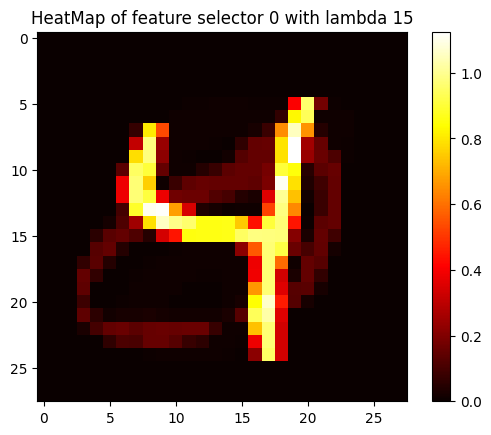

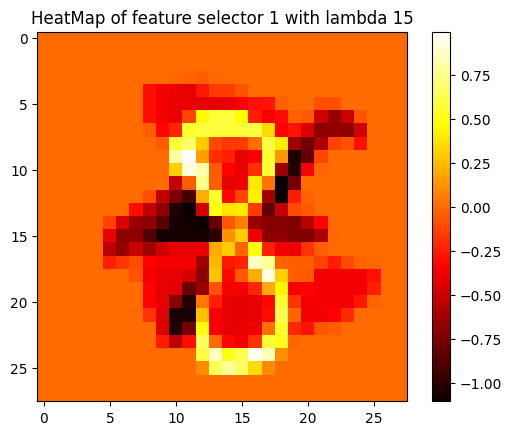

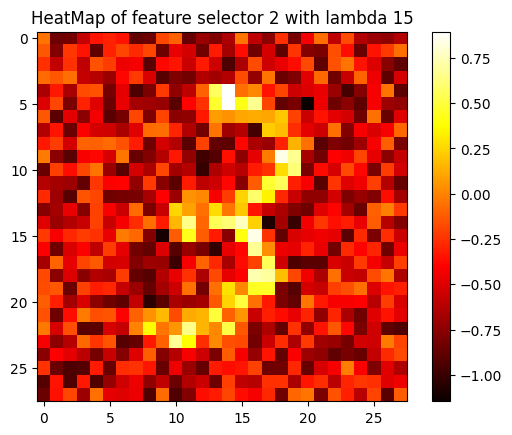

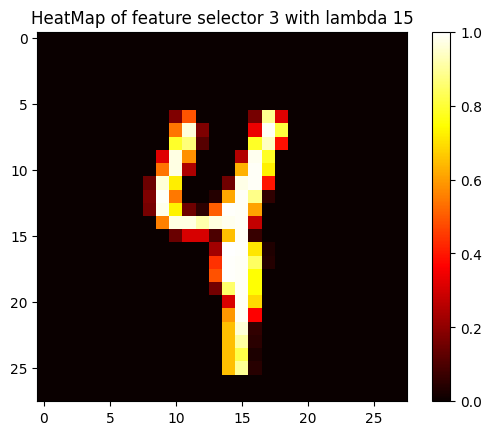

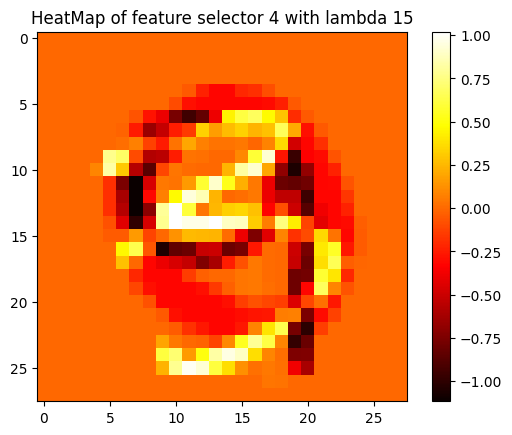

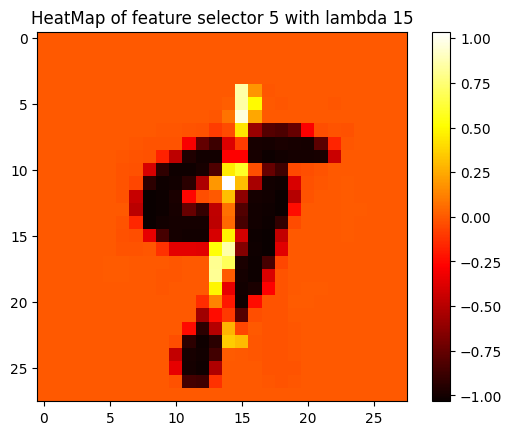

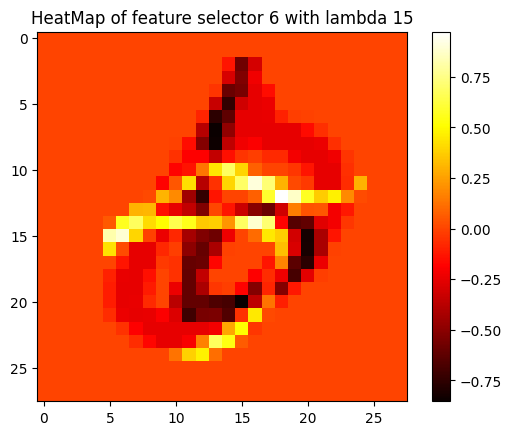

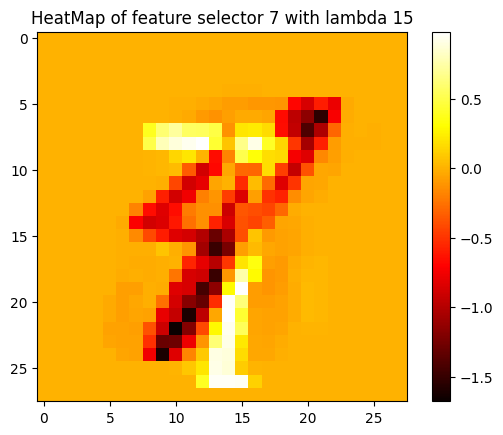

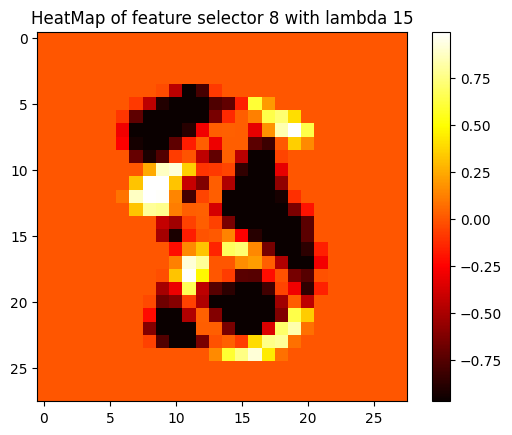

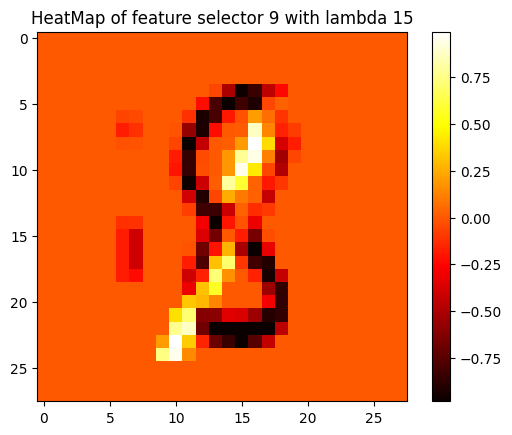

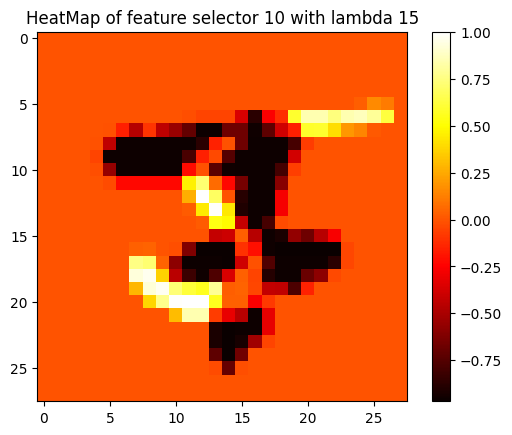

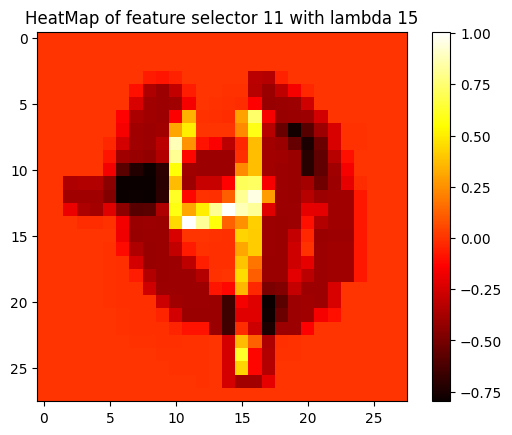

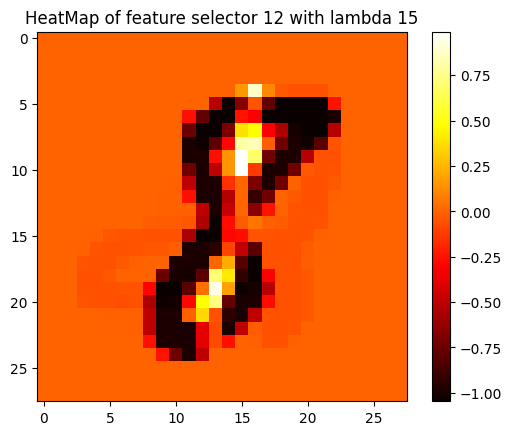

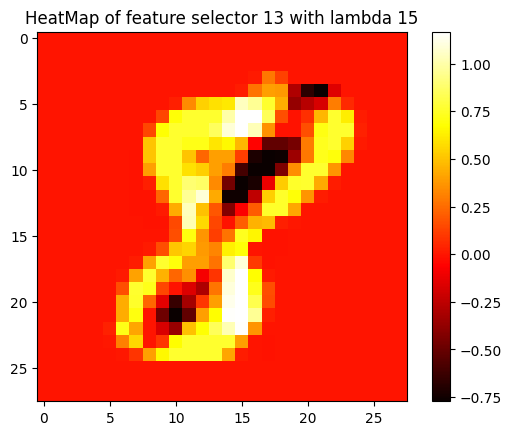

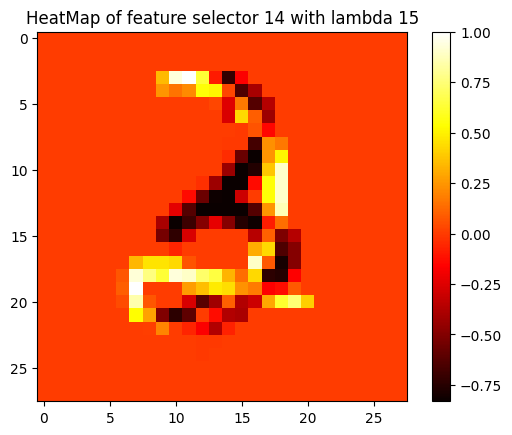

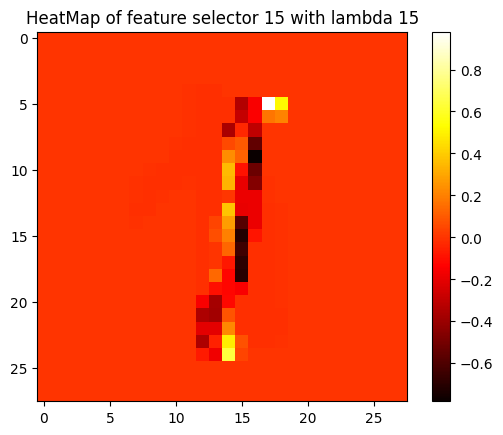

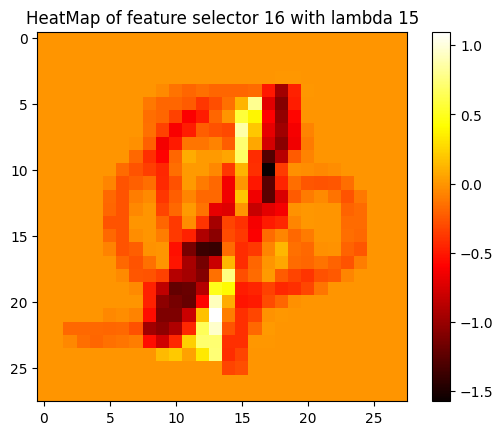

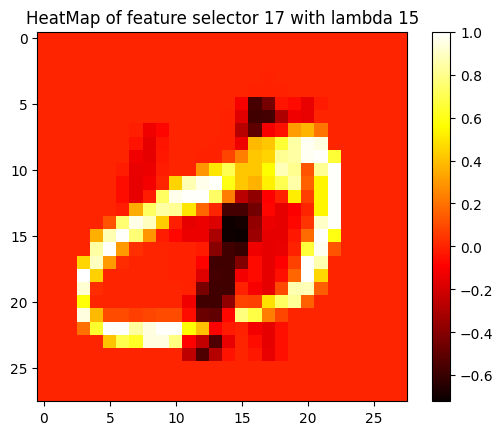

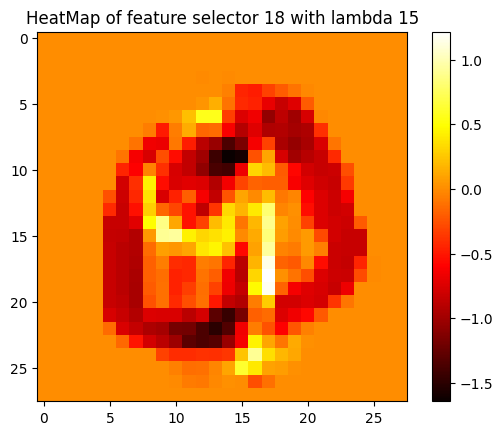

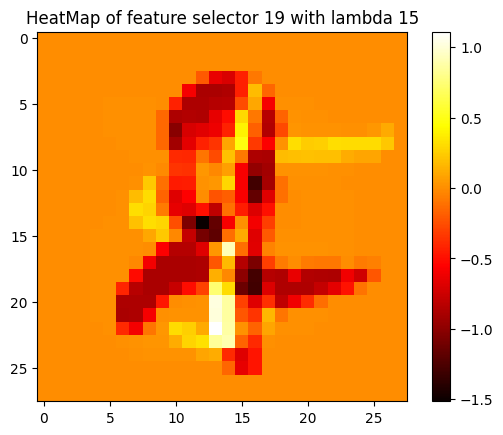

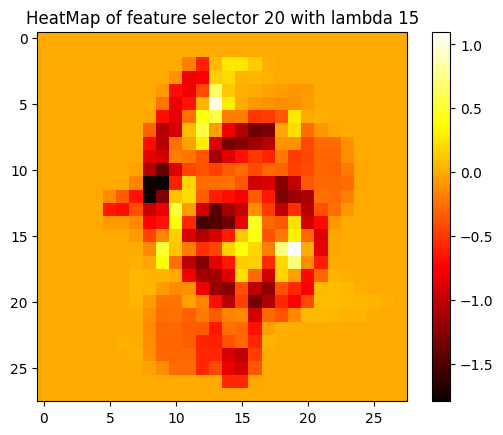

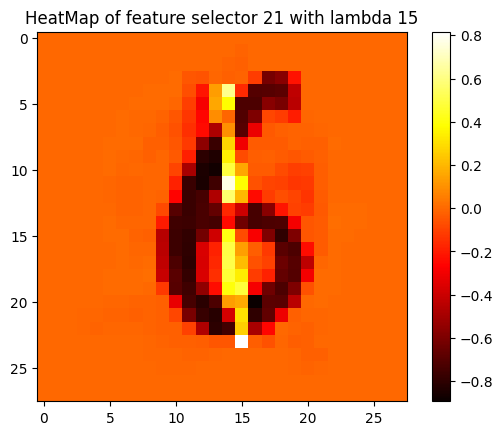

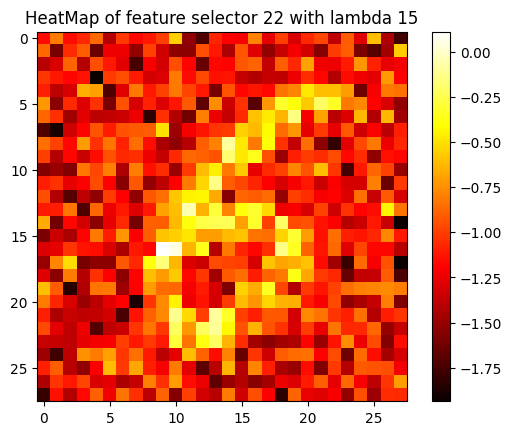

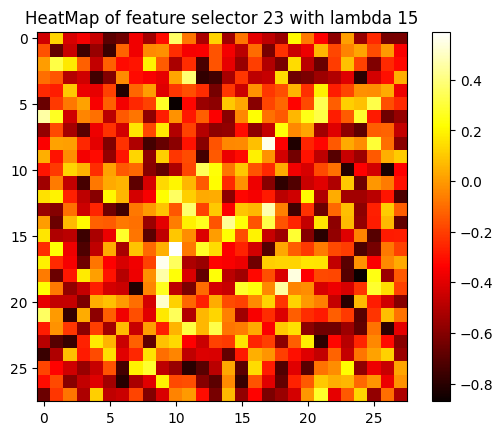

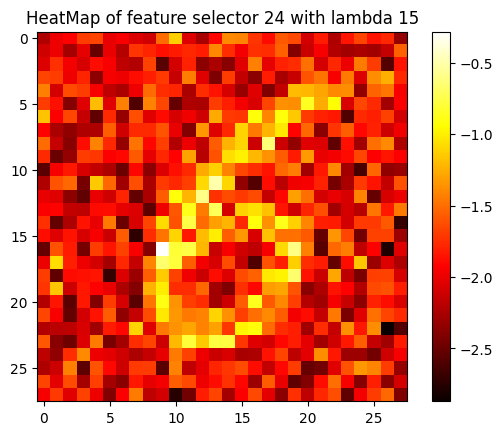

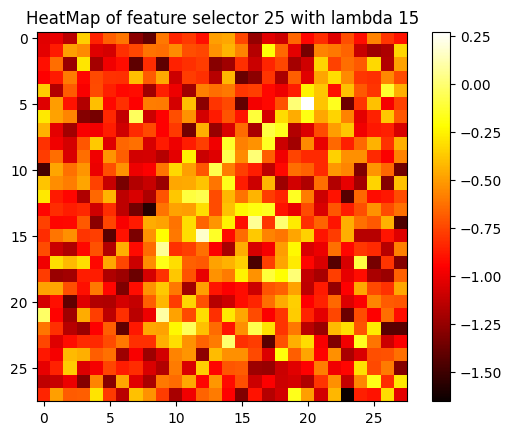

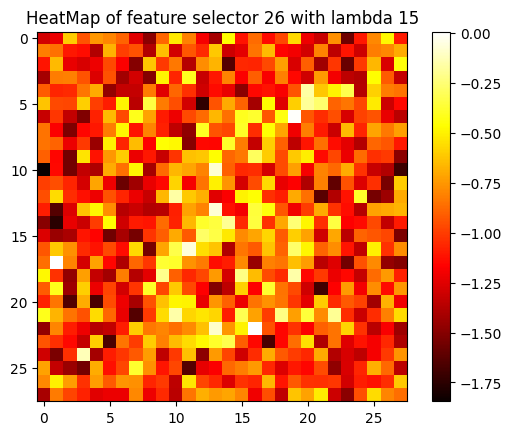

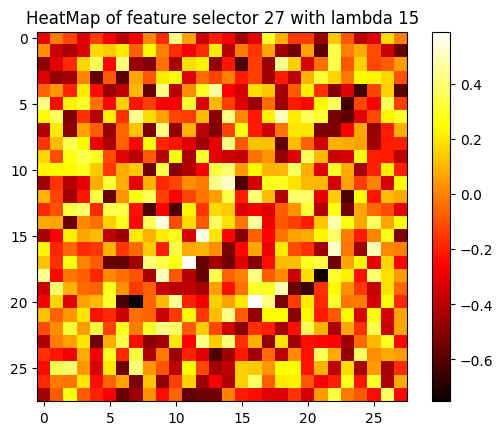

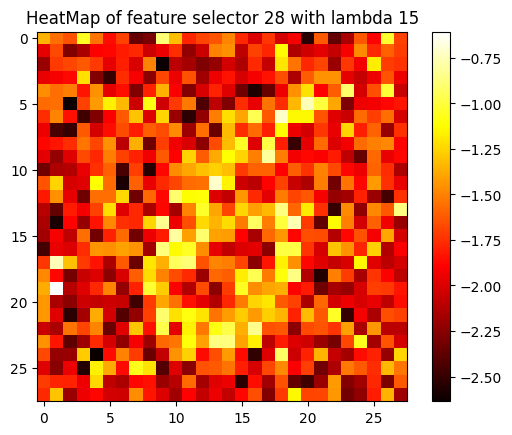

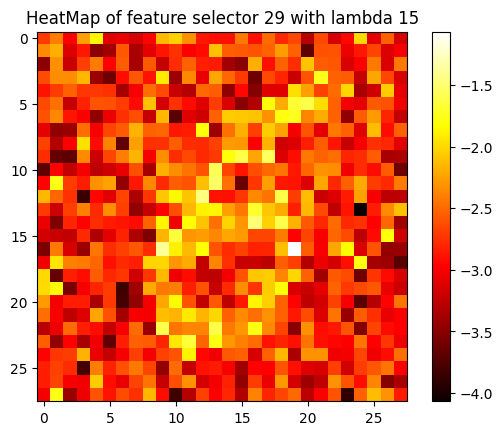

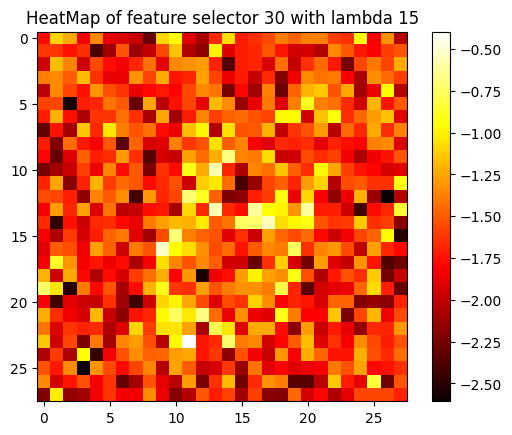

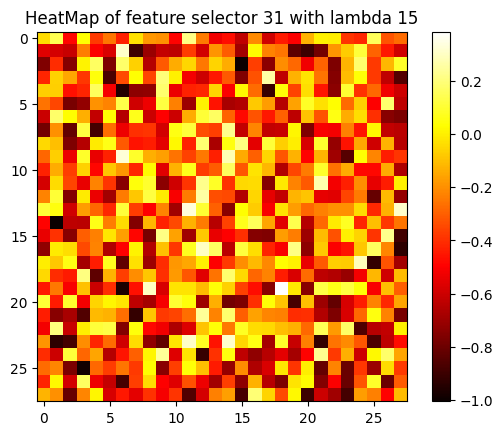

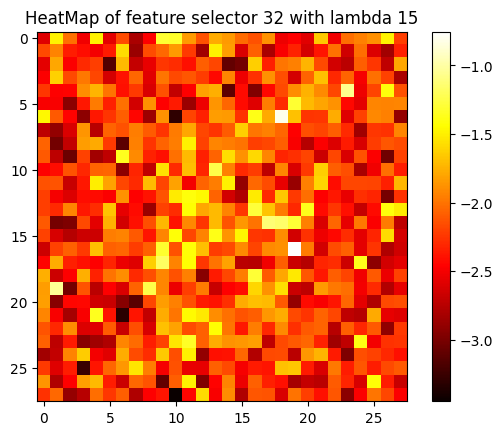

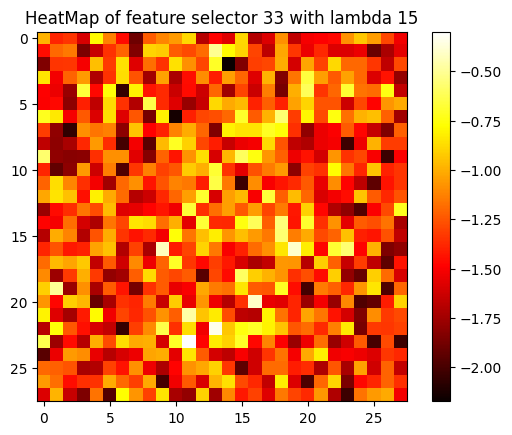

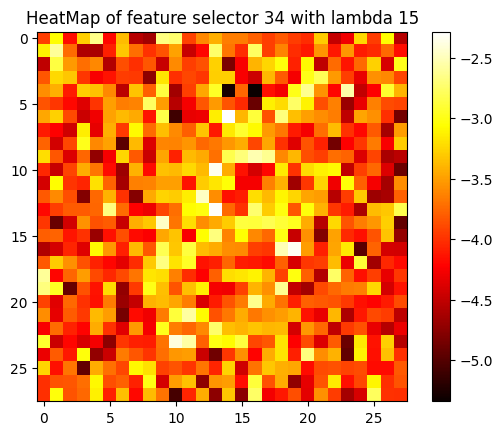

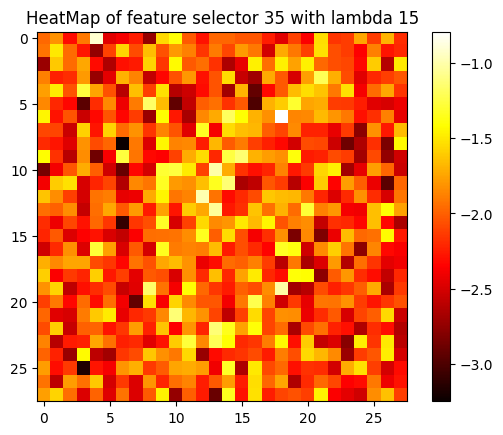

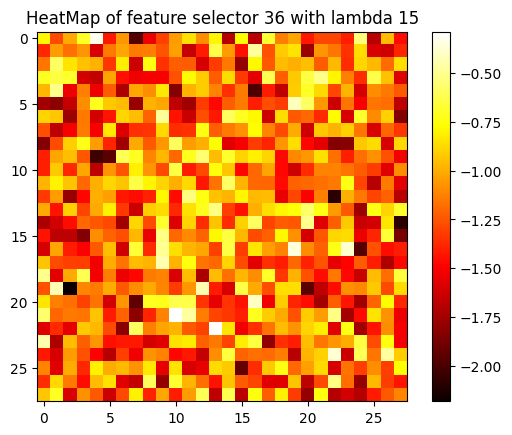

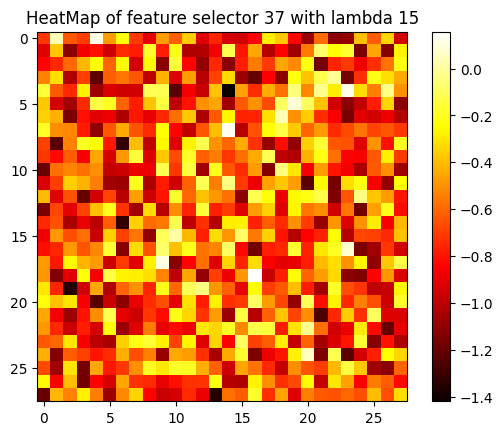

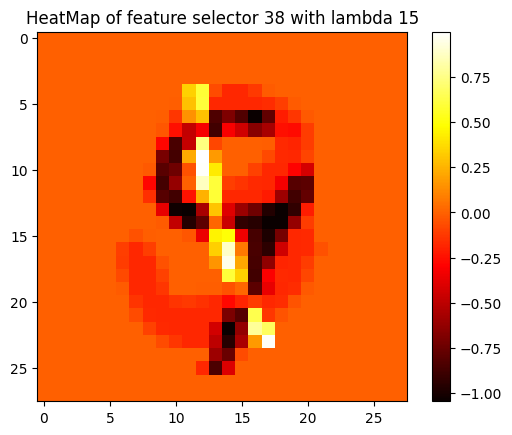

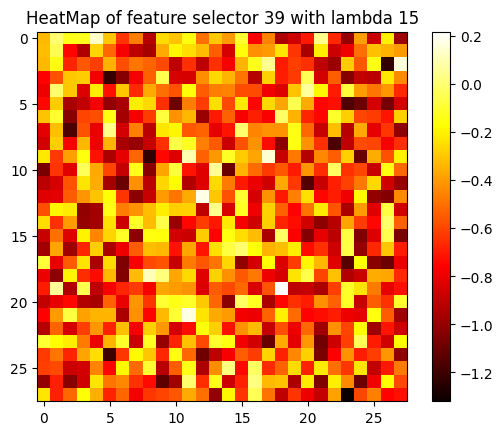

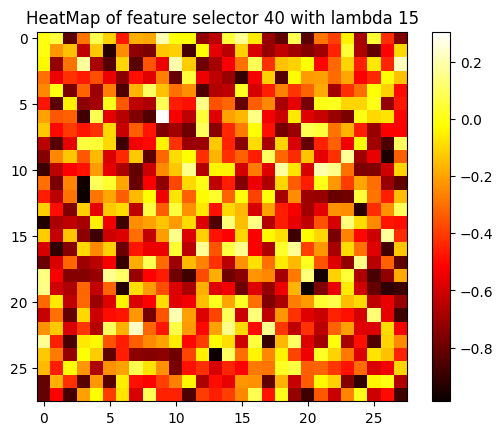

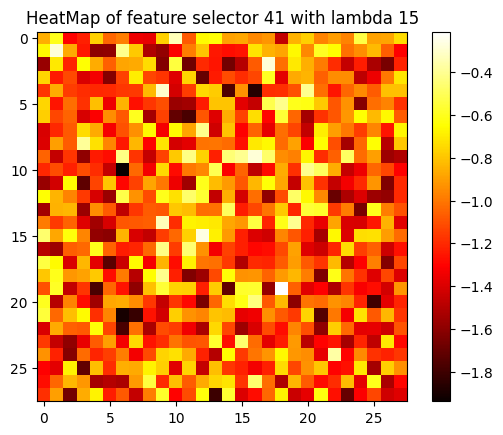

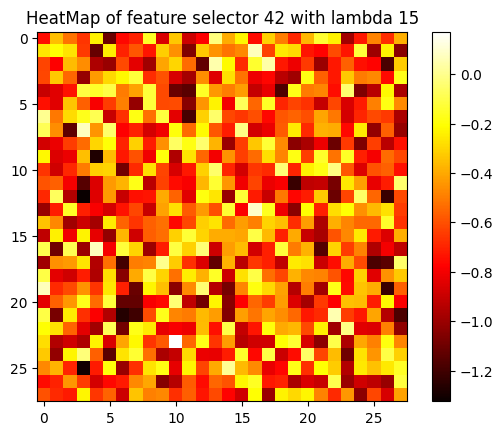

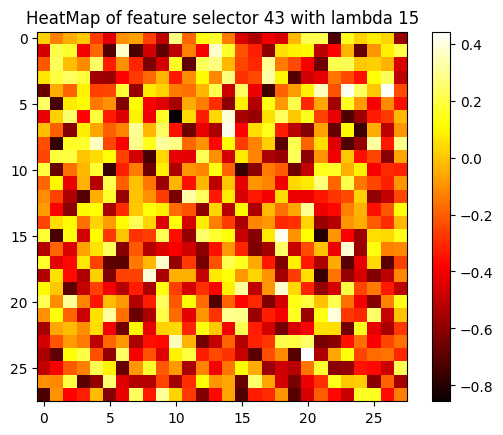

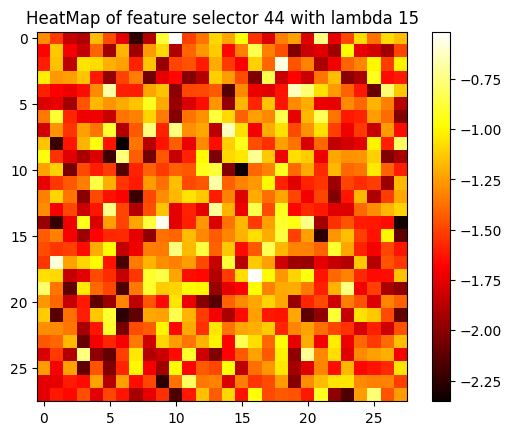

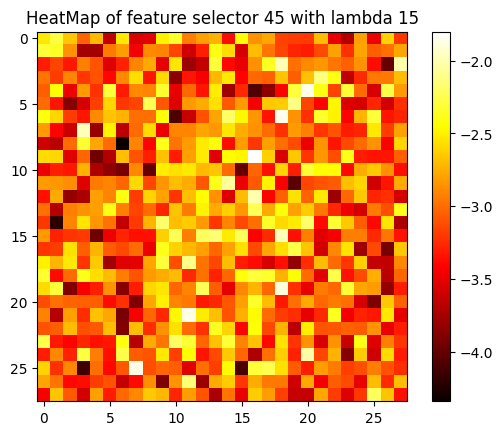

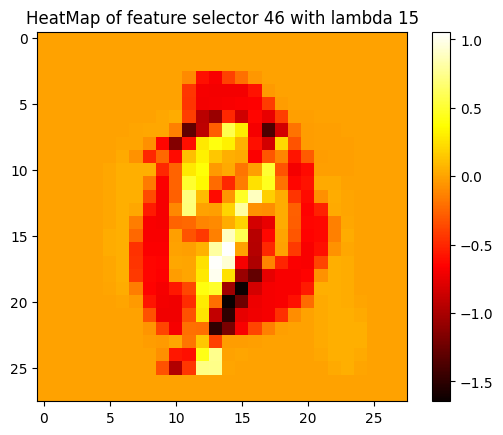

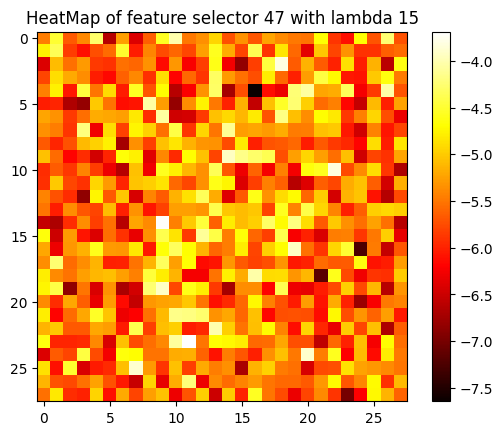

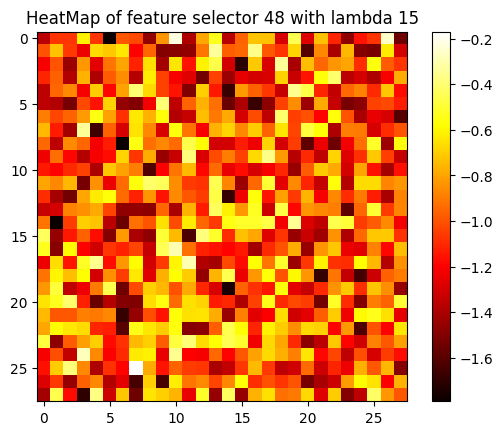

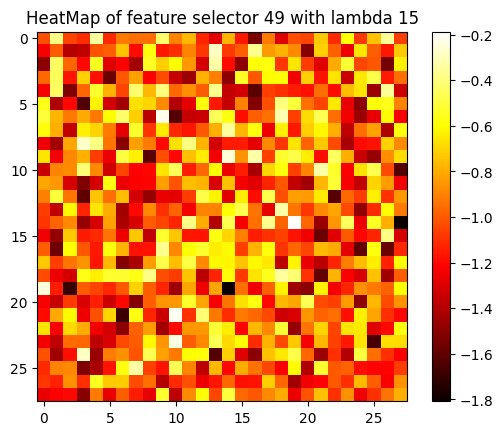

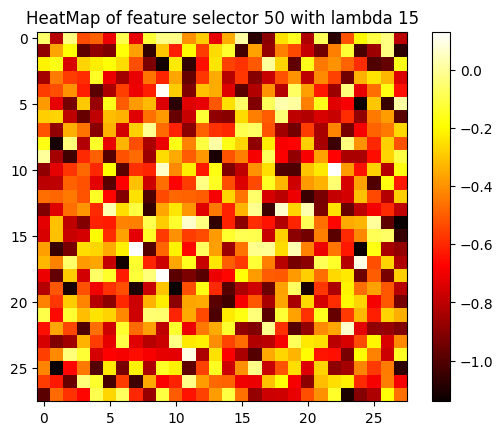

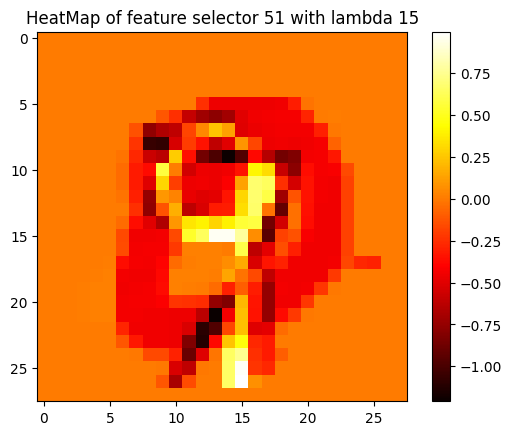

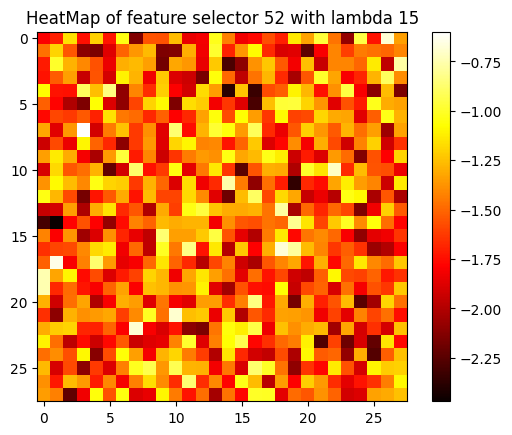

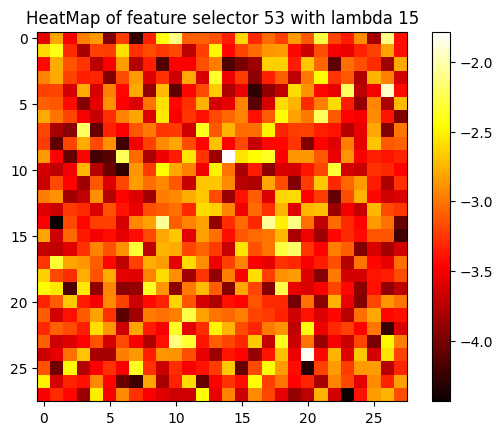

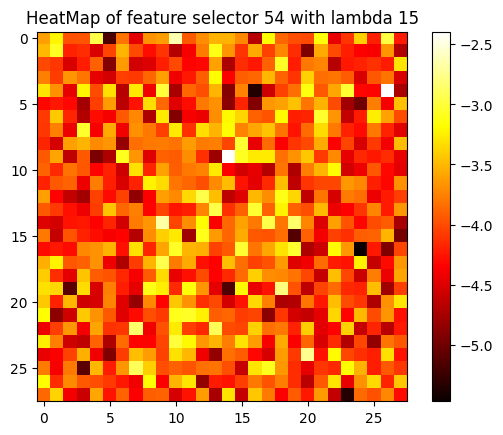

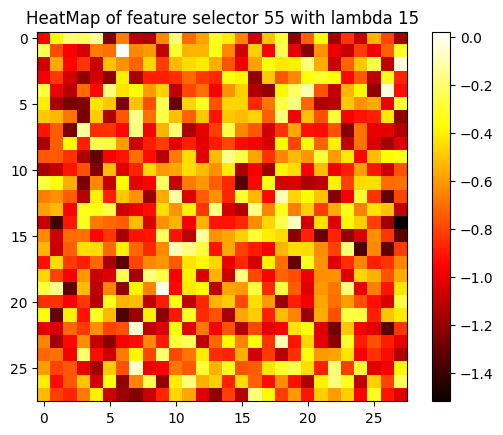

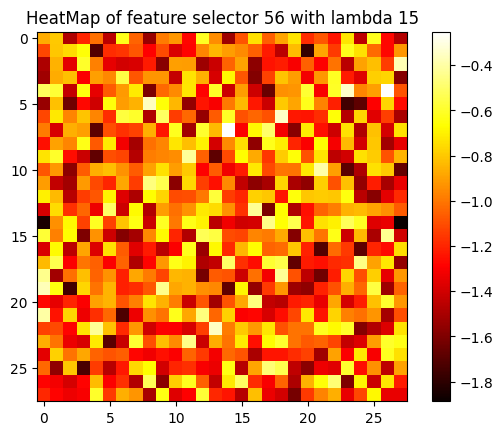

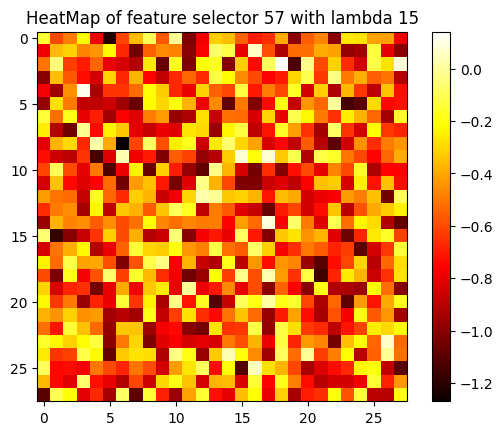

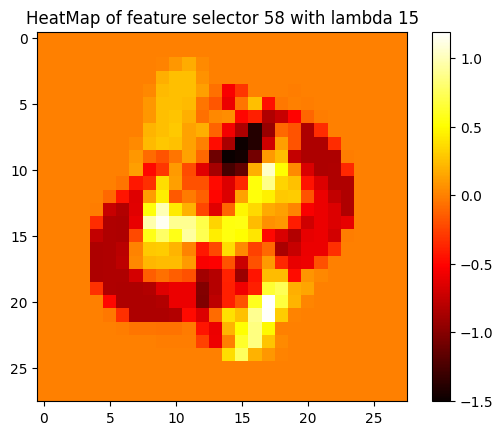

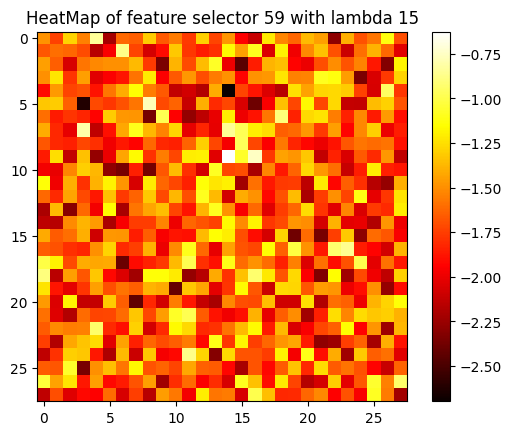

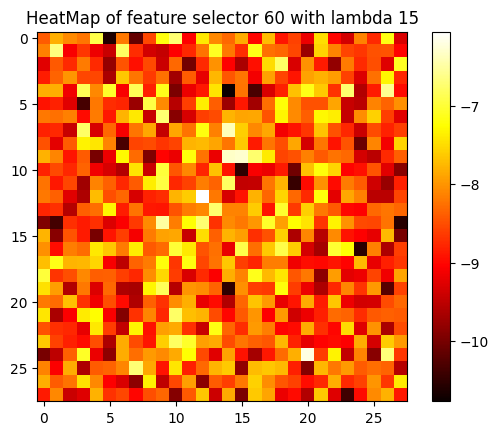

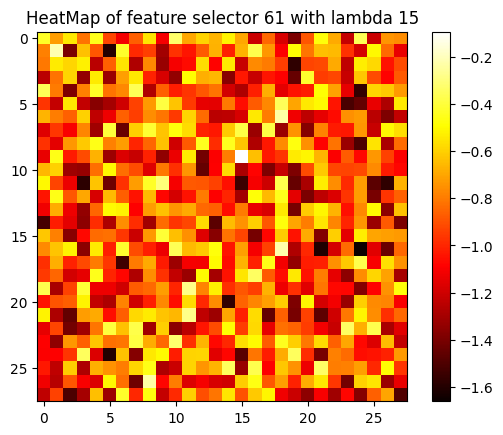

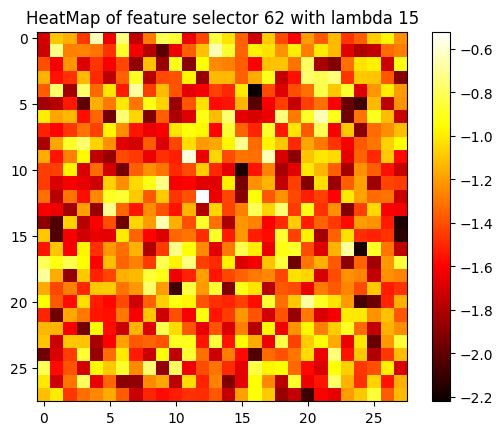

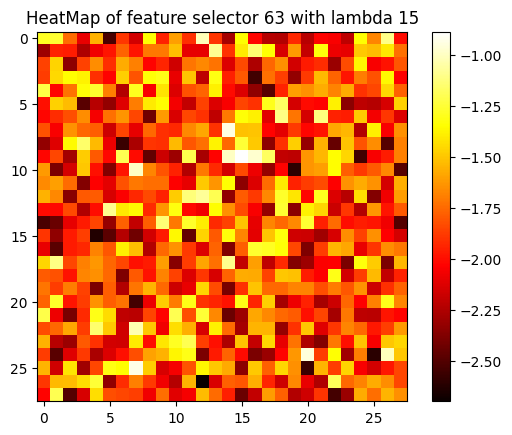

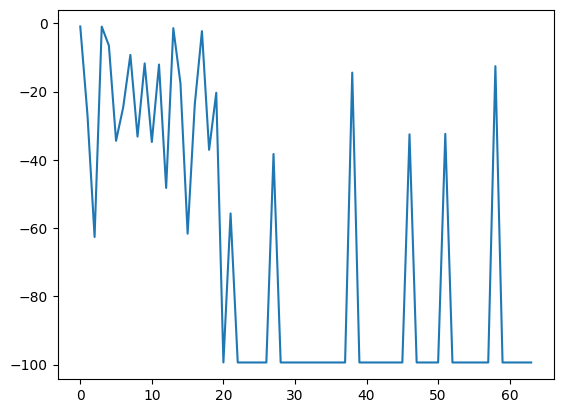

In [4]:
experiment.visualizeWeights(10, classifier=0)


Text(0, 0.5, 'Log Exponential Average')

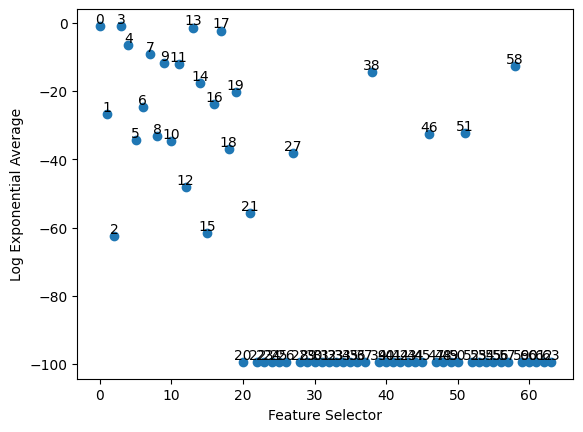

In [5]:
A=torch.log(experiment.model.hebbian_layer.exponential_average).tolist()

plt.scatter(range(len(A)), A)
for i, (x, y) in enumerate(zip(range(len(A)), A)):
    plt.text(x, y, f'{i}', ha='center', va='bottom')
plt.xlabel("Feature Selector")
plt.ylabel("Log Exponential Average")